In [1]:
!pip install --user -r requirements.txt

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

In [3]:
training_folder = "../../shared_data/training_mini"

In [4]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 

100	 Dateien wurden geladen.


In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Angenommen, Sie haben Ihre Daten bereits geladen:
# ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder)

# Konvertieren der EEG-Daten in das erforderliche Format
def prepare_data(data, channels, time_steps=400):
    num_records = len(data)
    formatted_data = np.empty((num_records, 3, time_steps)) # [Anzahl der Beispiele, 3 Kanäle, Zeitpunkte]

    for i in range(num_records):
        montages, montage_data, _ = get_3montages(channels[i], data[i])
        montage_data_resized = montage_data[:, :time_steps] if montage_data.shape[1] > time_steps else np.pad(montage_data, ((0,0), (0, time_steps - montage_data.shape[1])), 'constant')
        formatted_data[i] = montage_data_resized

    return formatted_data

# Vorbereiten der Daten
formatted_data = prepare_data(data, channels)

# Überprüfen der Dimensionen der formatierten Daten
print("Dimensionen der formatierten Daten:", formatted_data.shape)

# Stellen Sie sicher, dass die Dimensionen [num_records, 3, time_steps] sind
expected_shape = (len(data), 3, 400)  # 400 ist ein Beispiel für time_steps
if formatted_data.shape == expected_shape:
    print("Die Daten haben das erwartete Format.")
else:
    print(f"Unerwartetes Format. Erwartet: {expected_shape}, Erhalten: {formatted_data.shape}")


Dimensionen der formatierten Daten: (100, 3, 400)
Die Daten haben das erwartete Format.


Typ von formatted_data: <class 'numpy.ndarray'>
Form von formatted_data: (100, 3, 400)
Mittelwerte pro Kanal: [7.32394471e-06 4.57688373e-06 1.83262071e-06]
Standardabweichung pro Kanal: [4.10431713e-05 1.80359548e-04 2.13209484e-04]


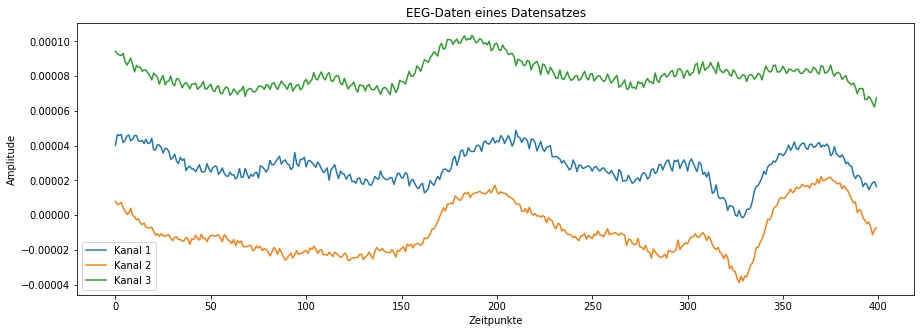

[[[-5.67627247e-05 -5.15747337e-05 -5.73730766e-05 -6.71387066e-05
   -6.50024751e-05 -5.92041322e-05 -6.22558916e-05 -7.20215217e-05
   -7.17163457e-05 -6.56128269e-05]
  [ 7.01904660e-06  3.35693533e-05  4.15039277e-05  1.22070376e-06
   -9.76563005e-06  3.87573443e-05  4.88281503e-05  5.18799097e-06
   -1.52587970e-06  2.65503067e-05]
  [-5.49316691e-06 -2.28881954e-05 -1.55639729e-05  4.27246315e-06
    0.00000000e+00 -1.83105564e-05 -1.73950285e-05  4.57763909e-06
    5.79834284e-06 -1.55639729e-05]]

 [[ 3.69262886e-05  4.85229743e-05  4.63867428e-05  3.63159368e-05
    3.57055849e-05  4.15039277e-05  4.39453352e-05  3.78418165e-05
    3.23486496e-05  4.45556871e-05]
  [-5.49316691e-06  3.32641774e-05  3.96728721e-05 -2.13623157e-06
   -1.06811579e-05  2.74658345e-05  4.36401593e-05  1.34277413e-05
   -3.66211127e-06  3.17382977e-05]
  [-2.74658345e-06 -3.57055849e-05 -3.63159368e-05 -3.05175939e-06
   -2.13623157e-06 -3.44848811e-05 -3.93676962e-05 -1.00708060e-05
   -2.44140751

In [6]:
print("Typ von formatted_data:", type(formatted_data))
print("Form von formatted_data:", formatted_data.shape)

print("Mittelwerte pro Kanal:", np.mean(formatted_data, axis=(0, 2)))
print("Standardabweichung pro Kanal:", np.std(formatted_data, axis=(0, 2)))

import matplotlib.pyplot as plt

# Wählen Sie einen Datensatz zum Plotten aus (hier den ersten Datensatz)
sample_data = formatted_data[80]

# Plot
plt.figure(figsize=(15, 5))
for i in range(sample_data.shape[0]):
    plt.plot(sample_data[i], label=f'Kanal {i+1}')
plt.title('EEG-Daten eines Datensatzes')
plt.xlabel('Zeitpunkte')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Anzeigen der ersten 10 Zeitpunkte der ersten 5 Datensätze
print(formatted_data[:5, :, :10])


In [25]:
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()  # Konvertieren zu torch.Tensor
        self.labels = torch.from_numpy(np.array(labels)).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Erstellen des Datasets
eeg_dataset = EEGDataset(formatted_data, np.array([label[0] for label in eeg_labels]))  # Hier nehmen wir nur den Teil "seizure_present" als Label


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Definieren der CNN-Schichten
        # Annahme: Jeder Eingang hat die Form [batch_size, 3, time_steps]
        # Dabei sind 3 die Anzahl der Kanäle (Montagen) und time_steps die Anzahl der Zeitpunkte pro Montage
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Anzahl der Zeitpunkte anpassen, falls notwendig
        # Beispiel: Wenn time_steps = 400, dann nach zwei Pooling-Layern: 400 -> 200 -> 100
        time_steps_adjusted = 100  # Anpassen basierend auf Ihrer tatsächlichen Zeitpunktzahl

        # Lineare Schichten
        self.fc1 = nn.Linear(32 * time_steps_adjusted, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 Ausgänge für binäre Klassifikation (Anfall vorhanden oder nicht)

    def forward(self, x):
        # Anwenden der Convolution und Pooling Schichten
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Umformen der Daten für die linearen Schichten
        x = x.view(x.size(0), -1)

        # Anwenden der linearen Schichten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Erstellen des Modells
model = CNN()


In [27]:
import torch
from torch import nn, optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
validation_split = 0.2
shuffle_dataset = True

# Erstellen eines EEGDataset mit Ihren Daten
eeg_dataset = EEGDataset(formatted_data, np.array([label[0] for label in eeg_labels]))

# Aufteilen der Daten in Trainings- und Validierungssets
train_size = int((1 - validation_split) * len(eeg_dataset))
val_size = len(eeg_dataset) - train_size
train_dataset, val_dataset = random_split(eeg_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_dataset)


In [28]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=25):
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        true_labels, predictions = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

        f1_train = f1_score(true_labels, predictions, average='weighted')

        # Validierung
        model.eval()
        val_true_labels, val_predictions = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_true_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())

        f1_val = f1_score(val_true_labels, val_predictions, average='weighted')

        # Aktualisieren Sie den besten F1-Score und speichern Sie das Modell, falls es verbessert wird
        if f1_val > best_f1:
            best_f1 = f1_val
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, F1 Train: {f1_train:.4f}, F1 Val: {f1_val:.4f}')

    print(f'Best F1 Score: {best_f1:.4f}')

# Trainieren des Modells
train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=25)


Epoch 1/25 - Loss: 1.3555, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 2/25 - Loss: 1.2364, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 3/25 - Loss: 1.3487, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 4/25 - Loss: 1.4375, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 5/25 - Loss: 1.3482, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 6/25 - Loss: 1.3135, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 7/25 - Loss: 1.3275, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 8/25 - Loss: 1.3749, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 9/25 - Loss: 1.3253, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 10/25 - Loss: 1.2762, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 11/25 - Loss: 1.2547, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 12/25 - Loss: 1.2750, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 13/25 - Loss: 1.2393, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 14/25 - Loss: 1.3355, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 15/25 - Loss: 1.3804, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 16/25 - Loss: 1.2478, F1 Train: 0.5121, F1 Val: 0.4500
Epoch 17/25 - Loss: 1.2468, F1 Tr

In [33]:
idx_record = 93
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaaac_s001_t000', 'aaaaaaac_s001_t001', 'aaaaaaac_s002_t000']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  400 Hz
Referenzsystem:  AR
EEG Labels: (seizure_present, onset, offset) (1, 34.8275, 63.0425)


In [35]:
# 1. Vorbereitung der Daten (bereits durchgeführt)
# formatted_data = prepare_data(data, channels)
# eeg_dataset = EEGDataset(formatted_data, labels)

# 2. Aufteilung in Trainings- und Validierungssets
train_size = int(0.8 * len(eeg_dataset))
val_size = len(eeg_dataset) - train_size
train_dataset, val_dataset = random_split(eeg_dataset, [train_size, val_size])

# 3. DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 4. Definition von Modell, Verlustfunktion und Optimierer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Anzahl der Trainingsepochen festlegen
num_epochs = 25  # oder eine andere Anzahl, die Sie für angemessen halten


# 5. Training des Modells
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation am Ende jeder Epoche
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}: Train Loss: {loss.item()}, Validation Accuracy: {100 * correct / total}%')

# 6. Evaluation (optional)
# Zusätzliche Evaluierungsmetriken können hier hinzugefügt werden


Epoch 1: Train Loss: 0.7214645743370056, Validation Accuracy: 50.0%
Epoch 2: Train Loss: 0.7824918031692505, Validation Accuracy: 50.0%
Epoch 3: Train Loss: 0.8050336837768555, Validation Accuracy: 50.0%
Epoch 4: Train Loss: 0.780208945274353, Validation Accuracy: 50.0%
Epoch 5: Train Loss: 0.7548825144767761, Validation Accuracy: 50.0%
Epoch 6: Train Loss: 0.7441065311431885, Validation Accuracy: 50.0%
Epoch 7: Train Loss: 0.7465652823448181, Validation Accuracy: 50.0%
Epoch 8: Train Loss: 0.7540916204452515, Validation Accuracy: 50.0%
Epoch 9: Train Loss: 0.7638959884643555, Validation Accuracy: 50.0%
Epoch 10: Train Loss: 0.7706084251403809, Validation Accuracy: 50.0%
Epoch 11: Train Loss: 0.7732943892478943, Validation Accuracy: 50.0%
Epoch 12: Train Loss: 0.7656092643737793, Validation Accuracy: 50.0%
Epoch 13: Train Loss: 0.7607091665267944, Validation Accuracy: 50.0%
Epoch 14: Train Loss: 0.7602196931838989, Validation Accuracy: 50.0%
Epoch 15: Train Loss: 0.760347843170166, Val

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score

# Annahme: Folgende Klassen und Funktionen sind bereits definiert:
# - CNN (Ihr Modell)
# - EEGDataset (Ihre Dataset-Klasse)

# EEG-Daten laden und vorbereiten
formatted_data = prepare_data(data, channels)
eeg_dataset = EEGDataset(formatted_data, np.array([label[0] for label in eeg_labels]))

# Aufteilen in Trainings- und Validierungssets
train_size = int(0.8 * len(eeg_dataset))
val_size = len(eeg_dataset) - train_size
train_dataset, val_dataset = random_split(eeg_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Modell, Verlustfunktion und Optimierer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.05, weight_decay=5e-4)

# EarlyStopping Klasse
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0.1, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_min = 0
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_acc, model):

        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        
        # If the next change in precision is within the threshold we set, this time the precision is temporarily recorded
        # If this accuracy is maintained for more than five consecutive times, then early stop
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation accuracy changed apparently.'''
        if self.verbose:
            self.trace_func(f'Validation accuracy changed ({self.val_acc_min:.4f}% --> {val_acc:.4f}%).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_min = val_acc
    
    # ... [Unveränderter EarlyStopping Code] ...

# EarlyStopping Instanz
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.1, path='best_model.pt')

# Training
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    # Berechnung des Trainingsverlusts und der Genauigkeit
    train_loss = sum(train_loss) / len(train_loss)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validierung
    model.eval()
    val_loss = []
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_loss = sum(val_loss) / len(val_loss)
    val_accuracy = val_correct / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # EarlyStopping Prüfung
    early_stopping(val_accuracy, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Laden des besten Modells
model.load_state_dict(torch.load('best_model.pt'))

# Weitere Schritte für Test / Evaluation / Anwendung des Modells ...


Epoch 1/25, Train Loss: 0.6770, Train Acc: 0.6500, Val Loss: 0.6767, Val Acc: 0.6000
Validation accuracy changed (0.0000% --> 0.6000%).  Saving model ...
Epoch 2/25, Train Loss: 0.6735, Train Acc: 0.6500, Val Loss: 0.6735, Val Acc: 0.6000
EarlyStopping counter: 1 out of 5
Epoch 3/25, Train Loss: 0.6259, Train Acc: 0.6500, Val Loss: 0.6849, Val Acc: 0.6000
EarlyStopping counter: 2 out of 5
Epoch 4/25, Train Loss: 0.6596, Train Acc: 0.6500, Val Loss: 0.7044, Val Acc: 0.6000
EarlyStopping counter: 3 out of 5
Epoch 5/25, Train Loss: 0.6019, Train Acc: 0.6500, Val Loss: 0.7098, Val Acc: 0.6000
EarlyStopping counter: 4 out of 5
Epoch 6/25, Train Loss: 0.7184, Train Acc: 0.6500, Val Loss: 0.6968, Val Acc: 0.6000
EarlyStopping counter: 5 out of 5
Early stopping


<All keys matched successfully>